To get this notebook to run, we are going to be using Zech's machine learning [hack_ml](https://github.com/rnaer/hack_ml) repo for microbiome datasets. This repo depends on `caret`, `doMC` and `optparse` (among others), so make sure you install those before continuing.

In [26]:
from IPython.display import display

In [1]:
%load_ext rmagic

/Users/yoshikivazquezbaeza/.virtualenvs/qiime-191/lib/python2.7/site-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


In [1]:
!git clone https://github.com/RNAer/hack_ml.git

Cloning into 'hack_ml'...
remote: Counting objects: 29, done.
remote: Total 29 (delta 0), reused 0 (delta 0), pack-reused 28
Unpacking objects: 100% (29/29), done.
Checking connectivity... done.


In [9]:
!mkdir -p classifier

#Calculate the receiver operator characteristic of the dataset

Note this will use all your CPUs for about 10-20 mins.

In [ ]:
!biom convert -i otu_table.15000.no-diarrhea.biom -o otu_table.15000.no-diarrhea.tsv --to-tsv \
--header-key taxonomy

In [3]:
!Rscript hack_ml/classification.R -i otu_table.15000.no-diarrhea.tsv \
-m mapping-file-full.alpha.L6index.txt -f disease_stat -o classifier/rstuff -r rf


*********************************
 Successfully loaded ~/.Rprofile
*********************************

Running command with args:
 /Library/Frameworks/R.framework/Resources/bin/exec/R --slave --no-restore --file=hack_ml/classification.R --args -i otu_table.15000.no-diarrhea.tsv -m mapping-file-full.alpha.L6index.txt -f disease_stat -o classifier/rstuff -r rf 
Loading required package: lattice
Loading required package: ggplot2
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Warning message:
package ‘ggplot2’ was built under R version 3.2.3 
========= disease_stat :
---- a glimpse of outcome:
outcome
healthy     IBD 
     85      64 
Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

Random Forest 

149 samples
801 predictors
  2 classes: 'healthy', 'IBD' 

No pre-proce

# Plot the ROC curve

HT to Zhenjiang Xu


Call:
plot.roc.default(x = ref, predictor = pred)

Data: pred in 4250 controls (ref FALSE) < 3200 cases (ref TRUE).
Area under the curve: 0.9101

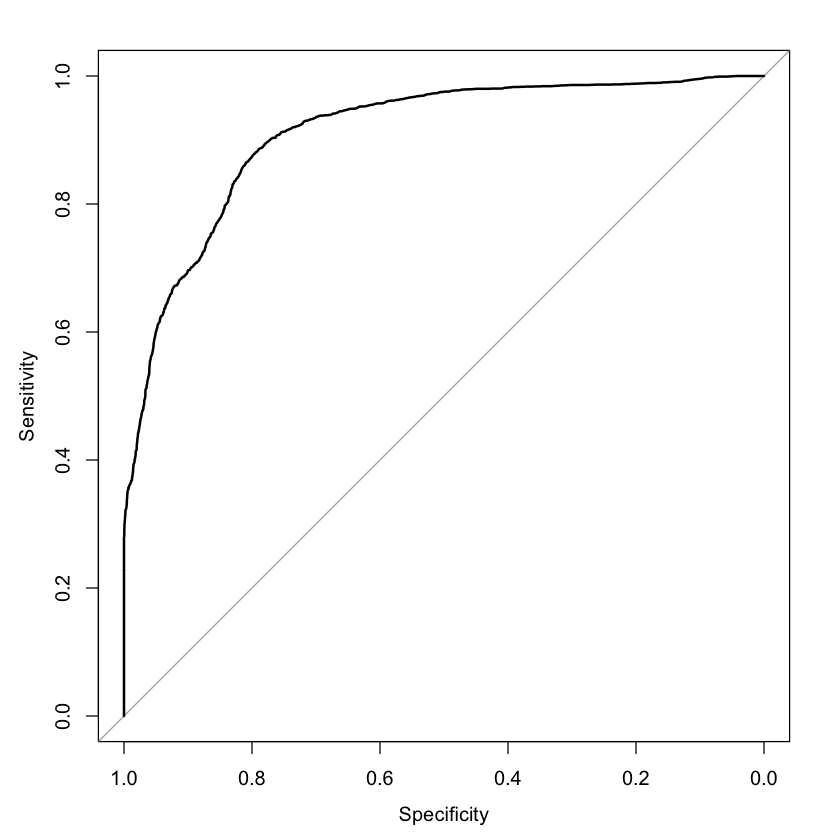

In [6]:
##%%R

load("classifier/rstuff.Rdata")
dog = big.tuned.list$disease_stat$rf
pred = pred = dog$pred$IBD
ref = (as.character(dog$pred$obs) == 'IBD')

library(pROC)
plot.roc(ref, pred)

## Plot curves for humans

In [7]:
!filter_samples_from_otu_table.py \
-i combined-gevers-suchodolski/otu-table.15000.fecal-only.hdf5.biom \
-o combined-gevers-suchodolski/otu-table.15000.fecal-only.humans-only.biom \
-s HOST_COMMON_NAME:human \
-m combined-gevers-suchodolski/mapping-file.standardized.alpha.amended.txt \
--output_mapping_fp combined-gevers-suchodolski/mapping-file.15000.fecal-only.humans-only.txt

In [8]:
!biom convert -i combined-gevers-suchodolski/otu-table.15000.fecal-only.humans-only.biom \
-o combined-gevers-suchodolski/otu-table.15000.fecal-only.humans-only.tsv.biom --to-tsv \
--header-key taxonomy

In [10]:
!mkdir -p combined-gevers-suchodolski/classifier

In [11]:
!Rscript hack_ml/classification.R \
-i combined-gevers-suchodolski/otu-table.15000.fecal-only.humans-only.tsv.biom \
-m combined-gevers-suchodolski/mapping-file.15000.fecal-only.humans-only.txt \
-f IBD_STATUS -o combined-gevers-suchodolski/classifier/rstuff -r rf


*********************************
 Successfully loaded ~/.Rprofile
*********************************

Running command with args:
 /Library/Frameworks/R.framework/Resources/bin/exec/R --slave --no-restore --file=hack_ml/classification.R --args -i combined-gevers-suchodolski/otu-table.15000.fecal-only.humans-only.tsv.biom -m combined-gevers-suchodolski/mapping-file.15000.fecal-only.humans-only.txt -f IBD_STATUS -o classifier/rstuff -r rf 
Loading required package: lattice
Loading required package: ggplot2
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Warning messages:
1: package ‘ggplot2’ was built under R version 3.2.3 
2: In readLines(filename) :
  incomplete final line found on 'combined-gevers-suchodolski/mapping-file.15000.fecal-only.humans-only.txt'
========= IBD_STATUS :
---- a glimpse of outcome:
outcome
Healthy     IBD 
     29     450 
Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new 


Call:
plot.roc.default(x = ref, predictor = pred)

Data: pred in 1450 controls (ref FALSE) < 22500 cases (ref TRUE).
Area under the curve: 0.612

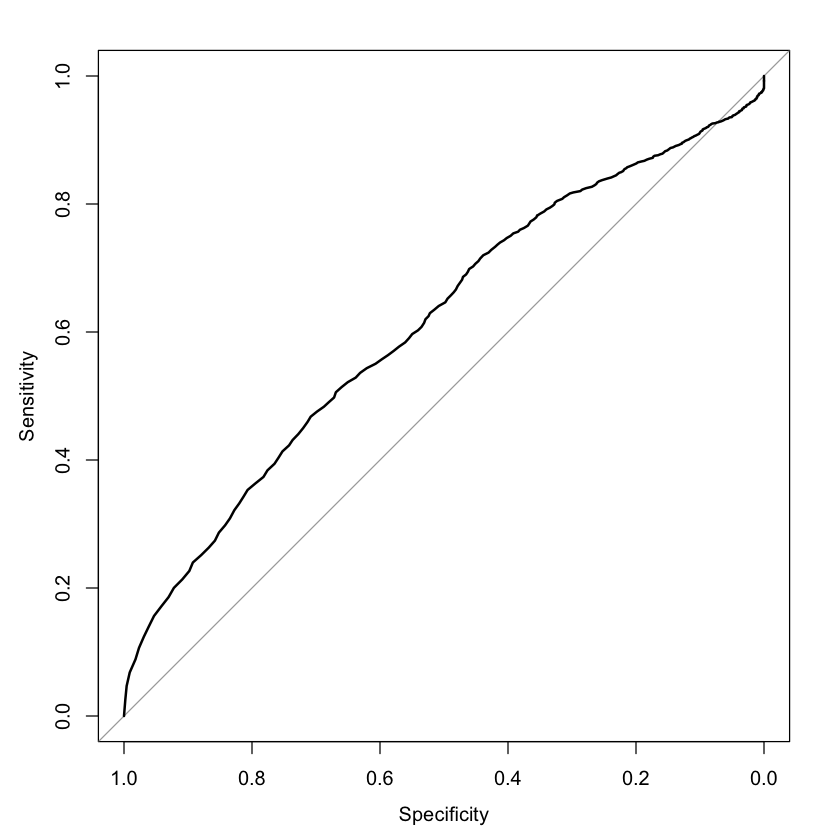

In [7]:
##%%R

load("combined-gevers-suchodolski/classifier/rstuff.Rdata")
human = big.tuned.list$IBD_STATUS$rf
pred = pred = human$pred$IBD
ref = (as.character(human$pred$obs) == 'IBD')

library(pROC)
plot.roc(ref, pred)

In [5]:
# Taken from hack_ml, thanks Zech!
plot.rf.roc <- function(models, labels, colors=c('red', 'black'), out='roc.pdf') {
    ## models is a list of models
    ## this only apply to random forest model
    require(caret)
    require(pROC)
    pdf(out)
    for (ii in 1:length(models)) {
        model = models[[ii]]
        pred <- model[['pred']]
        pred.tuned <- pred[ pred[['mtry']] == model[['bestTune']][1,'mtry'], ]
        response <- factor(pred.tuned[['obs']])
        prediction <- pred.tuned[[levels(response)[1]]]
        tuned.roc <- roc(response = response,
                         predictor = prediction)
        labels[ii] <- paste(labels[ii], ' (AUC:', round(tuned.roc$auc[1],3), ')', sep='')
        ## plot(tuned.roc, percent=TRUE)
        if (ii==1) {
            plot.roc(response, prediction,
                     main='ROC', print.thres=seq(0.4, 0.9, 0.1),# print.auc=T,
                     percent=TRUE, col=colors[ii])
        } else {
            lines.roc(response, prediction,
                      percent=TRUE, col=colors[ii], add=T)
        }
    }

    legend("bottomright", legend=labels, col=colors, lwd=2)
    dev.off()
}

In [10]:
plot.rf.roc(list(dog, human), list("Dogs", "Humans"), c("#1f78b4", "#a6cee3"),
            out="combined-gevers-suchodolski/roc-curve.pdf")

quartz 
     2

# View the table of feature importances.

In [2]:
load("classifier/rstuff.Rdata")
library(caret)

Loading required package: lattice
Loading required package: ggplot2
Warning message:
: package ‘ggplot2’ was built under R version 3.2.3

In [5]:
classifierResults = big.tuned.list$disease_stat$rf
importance = varImp(classifierResults)

Loading required package: randomForest
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin



In [9]:
importance

rf variable importance

  only 20 most important variables shown (out of 801)

        Importance
592170      100.00
594227       92.51
355269       89.11
364903       88.10
368219       87.26
1113256      87.16
582379       85.32
195651       83.10
308081       82.11
571458       81.80
363507       80.18
540982       79.78
4070491      79.00
1654477      78.97
354283       78.35
191593       76.76
845273       76.16
592866       76.08
360238       73.48
328283       70.52